In [1]:
from typing import Any, Dict, List, Optional
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
from database.models.Block import Block
from database.models.Tx import Tx
from database.models.Receipt import Receipt
from database.models.Ticker_ETHUSDT_15m import Ticker_ETHUSDT_15m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as fplt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
import ta
import eli5

import warnings
from datetime import datetime

import cloudpickle

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)

## *Problem Statement*

The goal of this project is to develop a machine learning model that can accurately predict the close price of the next candle on the Binance exchange for Ethereum. The model will use historical ticker data and ethereum blockchain data as input features, and will be trained on this data to identify patterns and trends that can be used to make predictions. <br>

The data for this project will be obtained from the Binance exchange for Ethereum, and will include historical ticker data and ethereum blockchain data. The ticker data will include information such as the open, high, low and close prices, as well as the volume of trades. The blockchain data will include information such as the number of transactions, block size, gas used, max priority fee per gas, gas price, the value of transactions.<br>

The proposed approach for this project is to use learning algorithms to train a model on the historical data and then use this model to make predictions on future data. The model will be trained using a linear regression algorithm as a baseline model. Additionally, the model will be fine-tuned using an XGBoost algorithm, which is a gradient boosting framework that uses decision trees as its base model. The XGBoost model will be tuned using techniques such as hyperparameter tuning to achieve the best performance. <br>

The expected outcome of this project is a machine learning model that can accurately predict the close price of the next candle on the Binance exchange for Ethereum, and provide insights and predictions that can assist traders in making informed decisions.

### Create session to DB

In [2]:
engine = create_engine("sqlite:///db.sqlite")
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)
session = Session()


### Get BLOCKS, TRANSACTIONS, RECEIPTS, TICKER data from DB

A class that stores and retrieves data from the SQLite database. It takes data of ticker in 15-minute candles and also retrieves data from the blockchain, and subtracts the blockchain data in every candle. It initializes several class variables such as _blocks, _txs, _receipts, and _ticker, which are all pandas DataFrames. It also initializes several other variables which are lists that store various statistics. The class has several methods, including the following:

- `get_blocks()` returns the class variable _blocks, which is a pandas DataFrame. 
- `get_txs()` returns the class variable _txs, which is a pandas DataFrame. 
- `get_receipts()` returns the class variable _receipts, which is a pandas DataFrame.
- `get_ticker()` returns the class variable _ticker, which is a pandas DataFrame.
- `fetch_from_database()` fetches data from the SQLite database and stores it in the class variables. It also calculates several statistics such as the first and last block numbers and timestamps. It also filters the ticker data to only include the timestamp between the first and last block timestamps.
- `agregate_data()` processes the data in the class variables and subtracts the blockchain data in every candle of the ticker data, then it returns a new pandas DataFrame.

In [3]:
class TickerBlocksDfConstructor():
    def __init__(self, session: Session) -> None:
        self._session = session

        self._blocks: pd.DataFrame
        self._txs: pd.DataFrame
        self._receipts: pd.DataFrame
        self._ticker: pd.DataFrame

        self._first_block_num: int = 0
        self._last_block_num: int = 0
        self._first_block_timestamp: int = 0
        self._last_block_timestamp: int = 0

        self._blocks_size_means: List[int] = []
        self._blocks_size_sums: List[int] = []
        self._blocks_gas_used_totals: List[int] = []
        self._blocks_base_fees_per_gas: List[int] = []
        self._txs_mean_per_block: List[int] = []
        self._blocks_gas_used_means: List[int] = []
        self._txs_max_fee_per_gas_mean: List[int] = []
        self._txs_count_per_candle: List[int] = []
        self._txs_gas_price_mean: List[int] = []
        self._txs_max_priority_per_gas_mean: List[int] = []
        self._txs_value_mean: List[int] = []
        self._txs_value_sum: List[int] = []
        self._rcpts_effec_gas_price_mean: List[int] = []
        self._rcpts_cumul_gas_used_mean: List[int] = []
        self._rcpts_contract_tx_mean_per_block: List[int] = []
        self._rcpts_contract_tx_count: List[int] = []

    def get_blocks(self)-> pd.DataFrame:
        return self._blocks
    
    def get_txs(self)-> pd.DataFrame:
        return self._txs

    def get_receipts(self)-> pd.DataFrame:
        return self._receipts

    def get_ticker(self)-> pd.DataFrame:
        return self._ticker
    
    def fetch_from_database(self) -> None:
        blocks = [row.__dict__ for row in self._session.query(Block).all()]
        self._blocks  = pd.DataFrame(blocks)
        del self._blocks["_sa_instance_state"]
        self._blocks.set_index("timestamp", inplace=True)
        self._first_block_num = int(self._blocks["blockNumber"].min())
        self._last_block_num = int(self._blocks["blockNumber"].max())
        self._first_block_timestamp = int(self._blocks.index.min())
        self._last_block_timestamp = int(self._blocks.index.max())

        txs = [row.__dict__ for row in self._session.query(Tx).all()]
        self._txs = pd.DataFrame(txs)
        del self._txs["_sa_instance_state"]

        receipts = [row.__dict__ for row in self._session.query(Receipt).all()]
        self._receipts = pd.DataFrame(receipts) 
        del self._receipts["_sa_instance_state"]

        ticker = [row.__dict__ for row in self._session.query(Ticker_ETHUSDT_15m).filter((Ticker_ETHUSDT_15m.open_time >= self._first_block_timestamp*1000) & (Ticker_ETHUSDT_15m.close_time <= self._last_block_timestamp*1000))]
        self._ticker = pd.DataFrame(ticker) 
        del self._ticker["_sa_instance_state"]
        

    def aggregate_data(self) -> pd.DataFrame:
        data = self._ticker.copy()
        for index, tick in self._ticker.iterrows():
            block_timestamp = self._blocks.index*1000
            blocks = self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["blockNumber"].tolist()

            self._blocks_size_sums.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].sum())
            self._blocks_size_means.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["size"].mean())
            self._blocks_base_fees_per_gas.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["baseFeePerGas"].mean())
            self._blocks_gas_used_totals.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].sum())
            self._blocks_gas_used_means.append(self._blocks[(block_timestamp >= tick["open_time"]) & (block_timestamp <= tick["close_time"])]["gasUsed"].mean())
            self._txs_mean_per_block.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "blockNumber"].count()/len(blocks))
            self._txs_count_per_candle.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "blockNumber"].count())
            self._txs_max_fee_per_gas_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "maxFeePerGas"].mean())
            self._txs_max_priority_per_gas_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "maxPriorityFeePerGas"].mean())
            self._txs_gas_price_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "gasPrice"].mean())
            self._txs_value_sum.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "value"].sum())
            self._txs_value_mean.append(self._txs.loc[self._txs["blockNumber"].isin(blocks), "value"].mean())
            self._rcpts_cumul_gas_used_mean.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "cumulativeGasUsed"].mean())
            self._rcpts_effec_gas_price_mean.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "effectiveGasPrice"].mean())
            self._rcpts_contract_tx_count.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "contractAddress"].count())
            self._rcpts_contract_tx_mean_per_block.append(self._receipts.loc[self._receipts["blockNumber"].isin(blocks), "contractAddress"].count()/len(blocks))

        data["blocks_size_sum"] = self._blocks_size_sums
        data["blocks_size_mean"] = self._blocks_size_means
        data["blocks_base_fee_per_gas"] = self._blocks_base_fees_per_gas
        data["txs_mean_per_block"] = self._txs_mean_per_block
        data["txs_count_per_candle"] = self._txs_count_per_candle
        data["txs_max_fee_per_gas_mean"] = self._txs_max_fee_per_gas_mean
        data["txs_max_priority_per_gas_mean"] = self._txs_max_priority_per_gas_mean
        data["txs_gas_price_mean"] = self._txs_gas_price_mean
        data["txs_value_sum"] = self._txs_value_sum
        data["txs_value_mean"] = self._txs_value_mean
        data["rcpts_cumul_gas_used_mean"] = self._rcpts_cumul_gas_used_mean
        data["rcpts_effec_gas_price_mean"] = self._rcpts_effec_gas_price_mean
        data["rcpts_contract_tx_count"] = self._rcpts_contract_tx_count
        data["rcpts_contract_tx_mean_per_block"] = self._rcpts_contract_tx_mean_per_block

        data['close_time'] = data['close_time'].values.astype(dtype='datetime64[ms]')
        data['open_time'] = data['open_time'].values.astype(dtype='datetime64[ms]')

        return data
    
    def fetch_and_merge_data(self) -> pd.DataFrame:
        self.fetch_from_database()
        return self.aggregate_data() 
    

### Creating base dataframes

In [4]:
data = TickerBlocksDfConstructor(session)
df = data.fetch_and_merge_data()
ticker = data.get_ticker()
blocks = data.get_blocks()
txs = data.get_txs()
receipts = data.get_receipts()

In [5]:
ticker.head(3)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume
0,1599.85,1663224300000,1634.90,1663225199999,84035,57187354.58,1580.10,1596.90,70719.24,113626302.03,35577.09
1,1619.31,1663225200000,1619.90,1663226099999,45892,27505391.65,1595.50,1599.86,36116.40,58098122.57,17091.59
2,1635.98,1663226100000,1655.00,1663226999999,51938,39454418.41,1617.51,1619.32,44313.70,72625581.84,24076.44


In [6]:
blocks.head(3)

,logsBloom,size,miner,stateRoot,difficulty,mixHash,baseFeePerGas,nonce,totalDifficulty,extraData,blockNumber,transactions,gasLimit,parentHash,transactionsRoot,gasUsed,receiptsRoot,uncles,blockHash,sha3Uncles
timestamp,,,,,,,,,,,,,,,,,,,,
1663224155,0x53a240c0610070015299420086041090205a11062100...,47274,0x829BD824B016326A401d083B33D092293333A830,0xb8d426f8c8b6ae1c34f6bebf904971be1611c29e8889...,11043900012338719,0x3cb45555281bd222aa7ec335efab51e99313814e03cc...,37949635702,0xac2c3800025a764f,58749981610968571282265,0xe4b883e5bda9e7a59ee4bb99e9b1bc4b2e22,15537391,[HexBytes('0x7d354eee5c08004aa1b8a3a05e1cf9cd3...,30000000,0xd5b9efdd3659f5b635e0505d787d6b6cc3af4c660def...,0xd976f002afbac9fdf1b028336719b602b9f4660ca103...,16969164,0x6b4d994610806d8a5ed107996abc477688d4d0748763...,[],0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...
1663224156,0xffffffffffffffffffffffffffffffffffffffffffff...,16568,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0xfee48a40a2765ab31fcd06ab6956341d13dc2c4b9762...,11049842297455506,0x2df332ffb74ecd15c9873d3f6153b878e1c514495dfb...,38572377838,0x232b0043952c93d9,58749992660810868737771,0x617369612d65617374322d31763932,15537392,[HexBytes('0x720322369bd103b7c064db34bfdc43836...,30000000,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x82864b3a65d1ac1917c426d48915dca0fc966fbf3f30...,29990952,0x13c10513b52358022f800e2f9f1c50328798427b1b4a...,[],0x2b3ea3cd4befcab070812443affb08bf17a91ce382c7...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...
1663224162,0x00000400000000000000000000000000000000000000...,1636,0x829BD824B016326A401d083B33D092293333A830,0x4919dafa6ac8becfbbd0c2808f6c9511a057c21e4283...,11055787484078698,0x4cbec03dddd4b939730a7fe6048729604d4266e82426...,43391016710,0x62a3ee77461d4fc9,58750003716598352816469,0xe4b883e5bda9e7a59ee4bb99e9b1bc460021,15537393,[HexBytes('0xec9db5bfbcd30ad2e3070b626ed4f78ab...,30000000,0x2b3ea3cd4befcab070812443affb08bf17a91ce382c7...,0xdd5eec02b019ff76e359b09bfa19395a2a0e97bc01e7...,29991429,0xbaa842cfd552321a9c2450576126311e071680a12580...,[],0x55b11b918355b1ef9c5db810302ebad0bf2544255b53...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...


In [7]:
txs.head(3)

,accessList,nonce,maxFeePerGas,blockNumber,r,maxPriorityFeePerGas,chainId,s,addressFrom,addressTo,gas,transactionIndex,gasPrice,type,tx_hash,v,blockHash,input,value
0,[],0,69420314159.00,15537391,0xede9e1e43a67b0dfde7df183443c56631a08c0d65609...,69420314159.00,0x1,0x7e74cadb53697ae766e0eecb016f47273249cbbf5fb4...,0xB578405Df1F9D4dFdD46a0BD152D518d4c5Fe0aC,0xc86E1A7a4AA5A9B17f6997a59B311835fc95e975,169420,0,69420314159,0x2,0x7d354eee5c08004aa1b8a3a05e1cf9cd348ee88be456...,1,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x7fec8d38,0.00
1,[],106,69000000000.00,15537391,0x6635d7f62a10fdfd60f56fc09b6b43b9a5b03d06c5f5...,69000000000.00,0x1,0x6f1b0bcc0b4f4fbb34e0d947b289b09d33202ac73498...,0x122B96a341Ab8da83EB86F4DceFAA4b1D43125E9,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,180000,1,69000000000,0x2,0x105acb5c3118b319e0bd2a50e1e1f5c71f2761337efc...,0,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00
2,[],72,70000000000.00,15537391,0xe1b20697c1a14b05fb9ab2ddec5c3eb86984b4514cff...,20000000000.00,0x1,0x6890a1ebfd367dacf41f7aab7cf446f87af6aab2d461...,0xdf0e3867920D812b74D05B19Da043679F1082512,0x7Bc25283a29A3888CAb4555Ea86fF1a8C18Cc90a,180000,2,57949635702,0x2,0x2c6d2799f6a4d958264297a10a0782c1eec6cd6f22dc...,0,0x2f1dc309c7cc0a5a2e3b3dd9315fea0ffbc53c56f923...,0x1249c58b,0.00


In [8]:
ticker.head(3)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume
0,1599.85,1663224300000,1634.90,1663225199999,84035,57187354.58,1580.10,1596.90,70719.24,113626302.03,35577.09
1,1619.31,1663225200000,1619.90,1663226099999,45892,27505391.65,1595.50,1599.86,36116.40,58098122.57,17091.59
2,1635.98,1663226100000,1655.00,1663226999999,51938,39454418.41,1617.51,1619.32,44313.70,72625581.84,24076.44


### Data info

The data taken from the database and stored in pandas DataFrames. The exact amount of data taken to create the final dataframe shown below in plot.

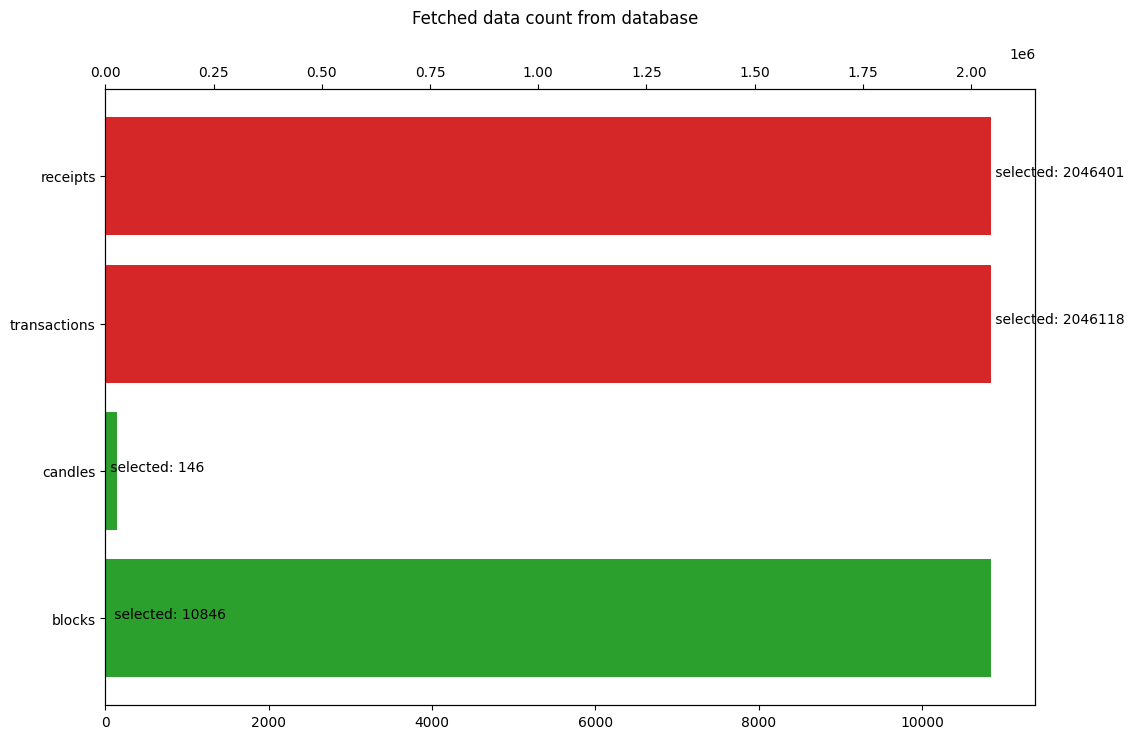

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('Fetched data count from database')
labels = ["blocks", "candles", "transactions", "receipts"]
values = [len(blocks), len(ticker), len(txs), len(receipts)]
ax.barh(["blocks", "candles", "transactions", "receipts"], [len(blocks), len(ticker), 0, 0], color="tab:green")
ax1 = ax.twiny()
ax1.barh(["blocks", "candles", "transactions", "receipts"], [0, 0, len(txs), len(receipts)], color="tab:red")
for index, value in enumerate(values):
    ax1.text(value, index,
             " selected: " + str(value))

plt.show()


### Some data from Binance

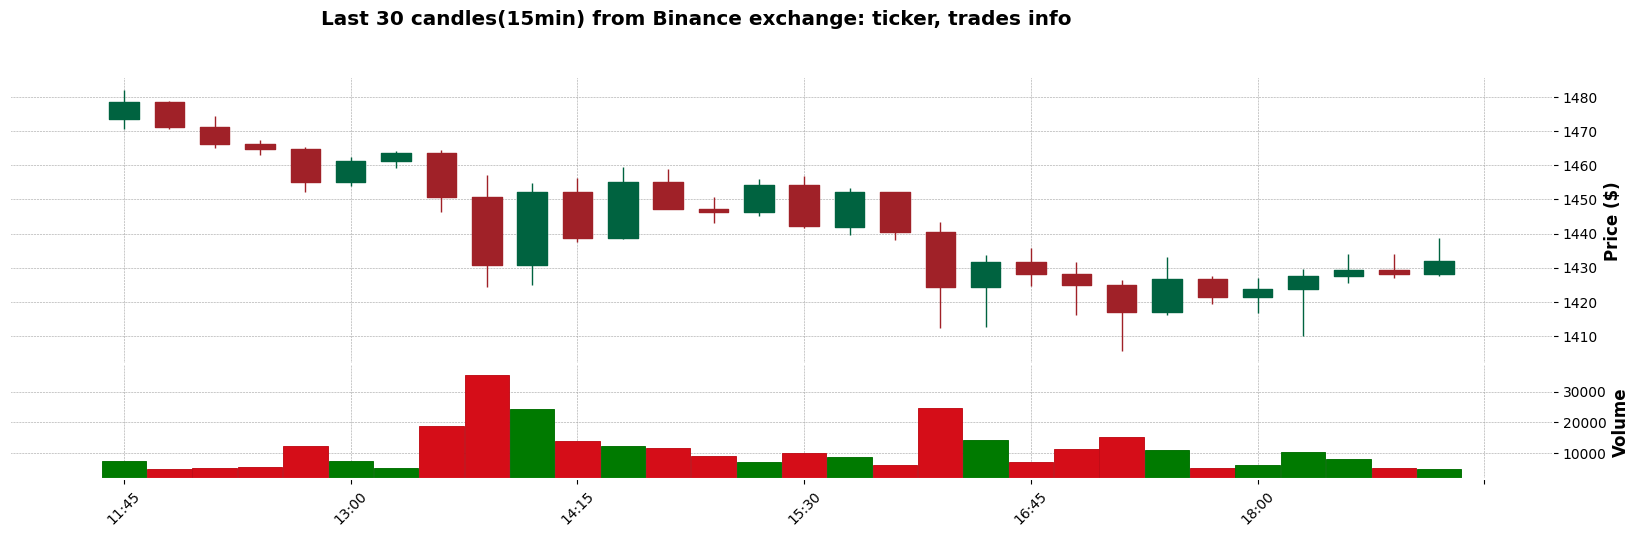

In [10]:

ticker = ticker.loc[:,("open_time", "open", "close", "high", "low", "volume")]
ticker['date'] = ticker['open_time'].values.astype(dtype='datetime64[ms]')
ticker.index = pd.DatetimeIndex(ticker['date'])
img = fplt.plot(
            ticker.tail(30),
            type='candle',
            style='charles',
            title='Last 30 candles(15min) from Binance exchange: ticker, trades info',
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            figratio=(82,22)
            )



### Some features from blockchain


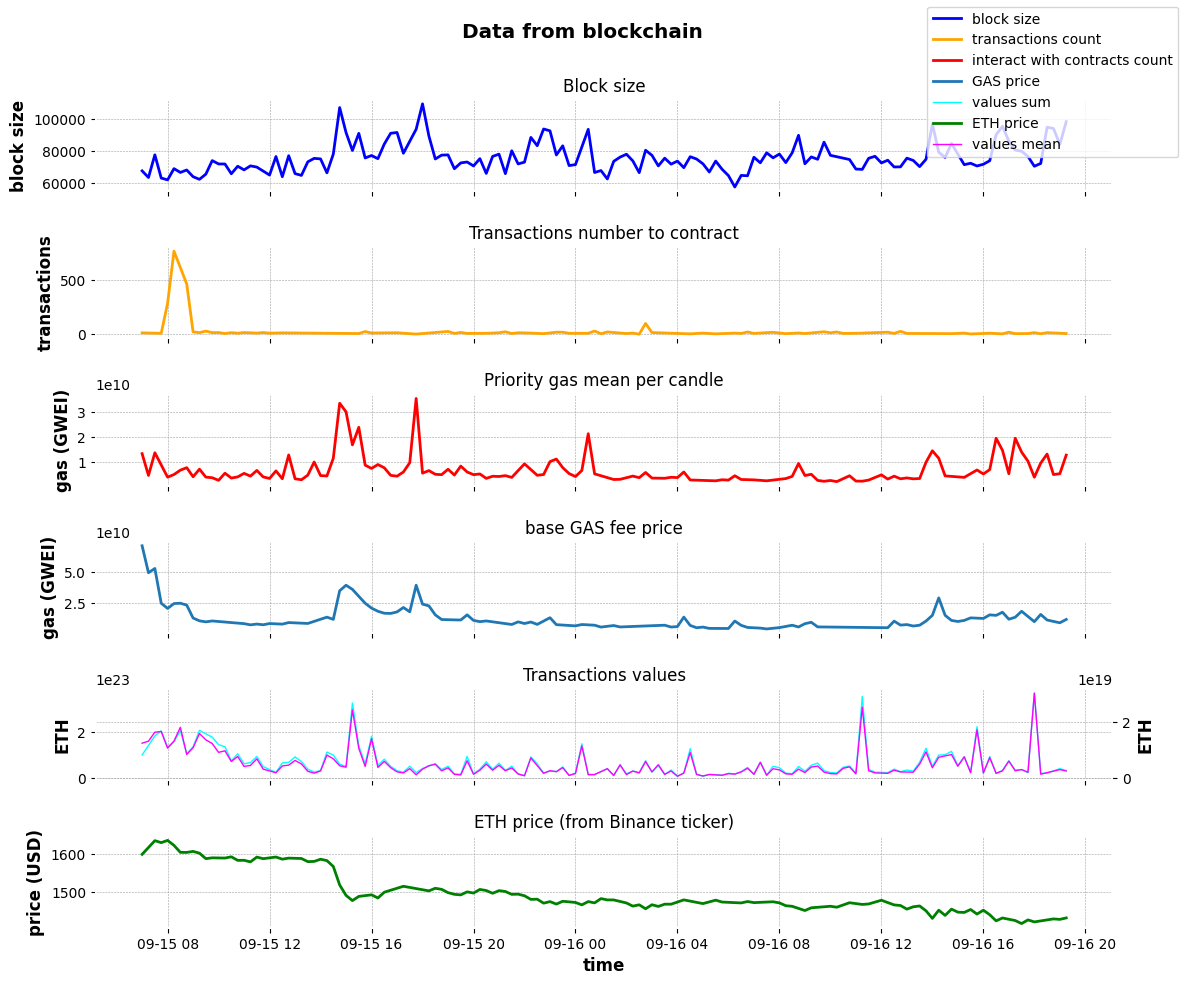

In [11]:
fig, axs = plt.subplots(6, sharex=True, figsize=(12,10))
fig.suptitle('Data from blockchain')

axs[0].plot(df["close_time"], df["blocks_size_mean"], color="blue", label="block size")
axs[0].set_title("Block size")
axs[0].set_ylabel("block size")

axs[1].plot(df["close_time"], df["rcpts_contract_tx_count"], color="orange", label="transactions count")
axs[1].set_ylabel("transactions")
axs[1].set_title("Transactions number to contract")

axs[2].plot(df["close_time"], df["txs_max_priority_per_gas_mean"], color="red", label="interact with contracts count")
axs[2].set_title("Priority gas mean per candle")
axs[2].set_ylabel("gas (GWEI)")

axs[3].plot(df["close_time"], df["blocks_base_fee_per_gas"], color="tab:blue", label="GAS price")
axs[3].set_title("base GAS fee price")
axs[3].set_ylabel("gas (GWEI)")

axs[4].plot(df["close_time"], df["txs_value_sum"], color="cyan", label="values sum", lw=1)
axs41= axs[4].twinx()
axs41.plot(df["close_time"], df["txs_value_mean"], color="magenta", label="values mean", lw=1)
axs41.set_ylabel("ETH")
axs[4].set_title("Transactions values")
axs[4].set_ylabel("ETH")

axs[5].plot(df["close_time"], df["close"], color="green", label="ETH price", lw=2)
axs[5].set_title("ETH price (from Binance ticker)")
axs[5].set_ylabel("price (USD)")
axs[5].set_xlabel("time")
fig.tight_layout(pad=2.0)
fig.legend();

### Final dataframe (Binance exchange ticker aggregated with blockchain data)

In [12]:
df.head()

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block
0,1599.85,2022-09-15 06:45:00,1634.90,2022-09-15 06:59:59.999,84035,57187354.58,1580.10,1596.90,70719.24,113626302.03,35577.09,5013042,67743.81,71178182467.20,110.65,8188,133267508917.13,13359332194.47,83174912105.29,101082683801613153337344.00,12345222740793008128.00,9252197.62,83174912105.29,14,0.19
1,1619.31,2022-09-15 07:00:00,1619.90,2022-09-15 07:14:59.999,45892,27505391.65,1595.50,1599.86,36116.40,58098122.57,17091.59,4705504,63587.89,49444776841.95,146.77,10861,94843006745.55,4588004919.18,54438118025.69,142006088173667349430272.00,13074863104103430144.00,11041895.97,54438118025.69,10,0.14
2,1635.98,2022-09-15 07:15:00,1655.00,2022-09-15 07:29:59.999,51938,39454418.41,1617.51,1619.32,44313.70,72625581.84,24076.44,5679812,77805.64,52896374370.37,154.78,11299,121158241807.01,13749810853.72,71875214220.03,183811686930809706512384.00,16267960609860139008.00,10105878.43,71875214220.03,3,0.04
3,1630.81,2022-09-15 07:30:00,1641.00,2022-09-15 07:44:59.999,31913,18323009.69,1622.91,1635.98,25041.88,40859483.37,11227.45,4743361,63244.81,24852211933.60,166.29,12472,71878680839.58,8553469797.47,32515465516.72,205942521677359559475200.00,16512389486638835712.00,10189175.72,32515465516.72,10,0.13
4,1636.65,2022-09-15 07:45:00,1637.13,2022-09-15 07:59:59.999,20985,12064050.39,1626.52,1630.82,16930.27,27642820.80,7388.72,4656999,62093.32,20707518254.73,170.44,12783,72810291642.60,3885366441.83,24884323388.83,135120782842834020466688.00,10570349905564735488.00,9555394.49,24884323388.83,285,3.80


A transformer class called CalculateTaTransformer that applies technical analysis (TA) features to a pandas DataFrame.
- ta.add_volume_ta: This function calculates volume-based technical indicators such as volume_adi, volume_obv, and volume_cmf.
- ta.add_others_ta: This function calculates additional technical indicators such as others_dr, others_dlr, and others_cr. 
- ta.add_volatility_ta: This function calculates volatility-based technical indicators such as volatility_bbhi, volatility_bbli, volatility_kchi and volatility_kclo.


In [13]:
class CalculateTaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[Any] = None) -> int:
        data = X.copy()
        data = ta.add_volume_ta(data, "high", "low", "close", "volume", fillna=True)
        data = ta.add_others_ta(data, "close", fillna=True)
        data = ta.add_volatility_ta(data, "high", "low", "close", fillna=True)
        data.drop(["volatility_bbhi", "volatility_kchi"], axis=1, inplace=True)
        return data

A transformer class called CreateLabelTransformer that creates a *`label`* for the next candle close price in the input DataFrame.

In [14]:
class CreateLabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[Any] = None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[Any] = None) -> int:
        data = X.copy()
        data.sort_values(by="close_time", ascending=False, inplace=True)
        data["next_candle_close"] = data.close.shift(periods=1)
        data.drop(data.head(1).index,inplace=True)
        return data

In [15]:
tr = CalculateTaTransformer()
data = tr.fit_transform(df)
tr = CreateLabelTransformer()
data = tr.fit_transform(data)
data.head(5)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
144,1428.09,2022-09-16 18:45:00,1434.02,2022-09-16 18:59:59.999,9087,3111003.87,1426.85,1429.33,5128.35,7333600.75,2175.46,6326379,84351.72,9115339210.23,188.41,14131,38657257169.10,5279793374.76,14174380675.50,41355529110989672808448.00,2926581919962470400.00,10098205.01,14174380675.50,11,0.15,-44464.38,-131590.93,0.07,-11103.54,93673.35,-218441.49,6.35,1428.49,28.08,1018.04,-0.09,-0.09,-10.74,1435.57,1459.45,1411.69,3.33,0.34,0.00,1424.80,1438.76,1410.85,1.96,0.62,0.00,1405.52,1459.39,1432.45,3.75,0.42,13.88,1.99,1431.92
143,1429.34,2022-09-16 18:30:00,1434.07,2022-09-16 18:44:59.999,13235,5890684.78,1425.46,1427.41,8009.81,11451676.31,4119.95,7077025,94360.33,10434948090.68,179.65,13474,46370946602.39,4940343779.67,15309412529.07,32171534076112816570368.00,2387675083576726528.00,9621058.41,15309412529.07,9,0.12,-41109.85,-126462.58,-0.01,-11885.72,1077081.62,-182859.28,36.78,1429.59,29.10,1018.93,0.14,0.14,-10.66,1435.70,1459.44,1411.96,3.31,0.37,0.00,1424.51,1440.85,1408.17,2.29,0.65,0.00,1405.52,1459.39,1432.45,3.75,0.44,14.62,1.96,1428.09
142,1427.41,2022-09-16 18:15:00,1429.48,2022-09-16 18:29:59.999,17555,7243086.01,1410.01,1423.78,10180.11,14457968.14,5099.96,6847408,95102.89,11359121400.25,174.24,12545,55066894149.06,13206306507.90,23275566233.43,22307681574033171677184.00,1778212959269284352.00,9601733.73,23275566233.43,16,0.22,-40319.10,-134472.39,-0.05,-16443.17,-414067.71,-298337.38,36.08,1430.63,23.40,1017.55,0.25,0.25,-10.78,1436.77,1461.19,1412.35,3.40,0.31,0.00,1425.90,1442.81,1409.00,2.37,0.54,0.00,1405.52,1464.63,1435.08,4.11,0.37,15.29,1.99,1429.34
141,1423.78,2022-09-16 18:00:00,1427.00,2022-09-16 18:14:59.999,11242,4262996.34,1416.82,1421.40,6022.79,8568122.67,2996.75,5430025,72400.33,15854573839.63,210.47,15785,62823469360.00,9579697216.22,24596470220.40,20292837686901223718912.00,1285577300405525760.00,11236641.74,24596470220.40,6,0.08,-48334.56,-144652.50,-0.07,-25342.66,-250156.41,-237261.26,-9.44,1432.81,31.08,1017.55,0.17,0.17,-11.01,1438.57,1465.20,1411.95,3.70,0.22,0.00,1428.51,1444.84,1412.17,2.29,0.36,0.00,1405.52,1464.63,1435.08,4.11,0.31,14.82,2.01,1427.41
140,1421.39,2022-09-16 17:45:00,1427.51,2022-09-16 17:59:59.999,9810,3423262.38,1419.27,1426.73,5228.45,7438408.20,2406.34,5156691,70639.60,10003476716.62,167.96,12261,51873769680.57,3866236062.51,14206069153.73,370485461544349303046144.00,30216577892859416576.00,8650512.58,14206069153.73,16,0.22,-50547.26,-150675.29,-0.05,-31965.52,-189907.09,-194212.22,54.75,1434.68,37.92,1017.55,-0.37,-0.37,-11.15,1440.45,1467.92,1412.98,3.81,0.15,0.00,1430.95,1447.80,1414.09,2.36,0.22,0.00,1405.52,1464.63,1435.08,4.10,0.27,15.34,1.98,1423.78


In [16]:
data.columns

Index(['close', 'open_time', 'high', 'close_time', 'number_of_trades',
       'taker_buy_quote_asset_volume', 'low', 'open', 'volume',
       'quote_asset_volume', 'taker_buy_base_asset_volume', 'blocks_size_sum',
       'blocks_size_mean', 'blocks_base_fee_per_gas', 'txs_mean_per_block',
       'txs_count_per_candle', 'txs_max_fee_per_gas_mean',
       'txs_max_priority_per_gas_mean', 'txs_gas_price_mean', 'txs_value_sum',
       'txs_value_mean', 'rcpts_cumul_gas_used_mean',
       'rcpts_effec_gas_price_mean', 'rcpts_contract_tx_count',
       'rcpts_contract_tx_mean_per_block', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'others_dr', 'others_dlr',
       'others_cr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_k

/var/folders/jt/jttvrgbx7pxgyn407jvmp9000000gn/T/ipykernel_17999/3303758053.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


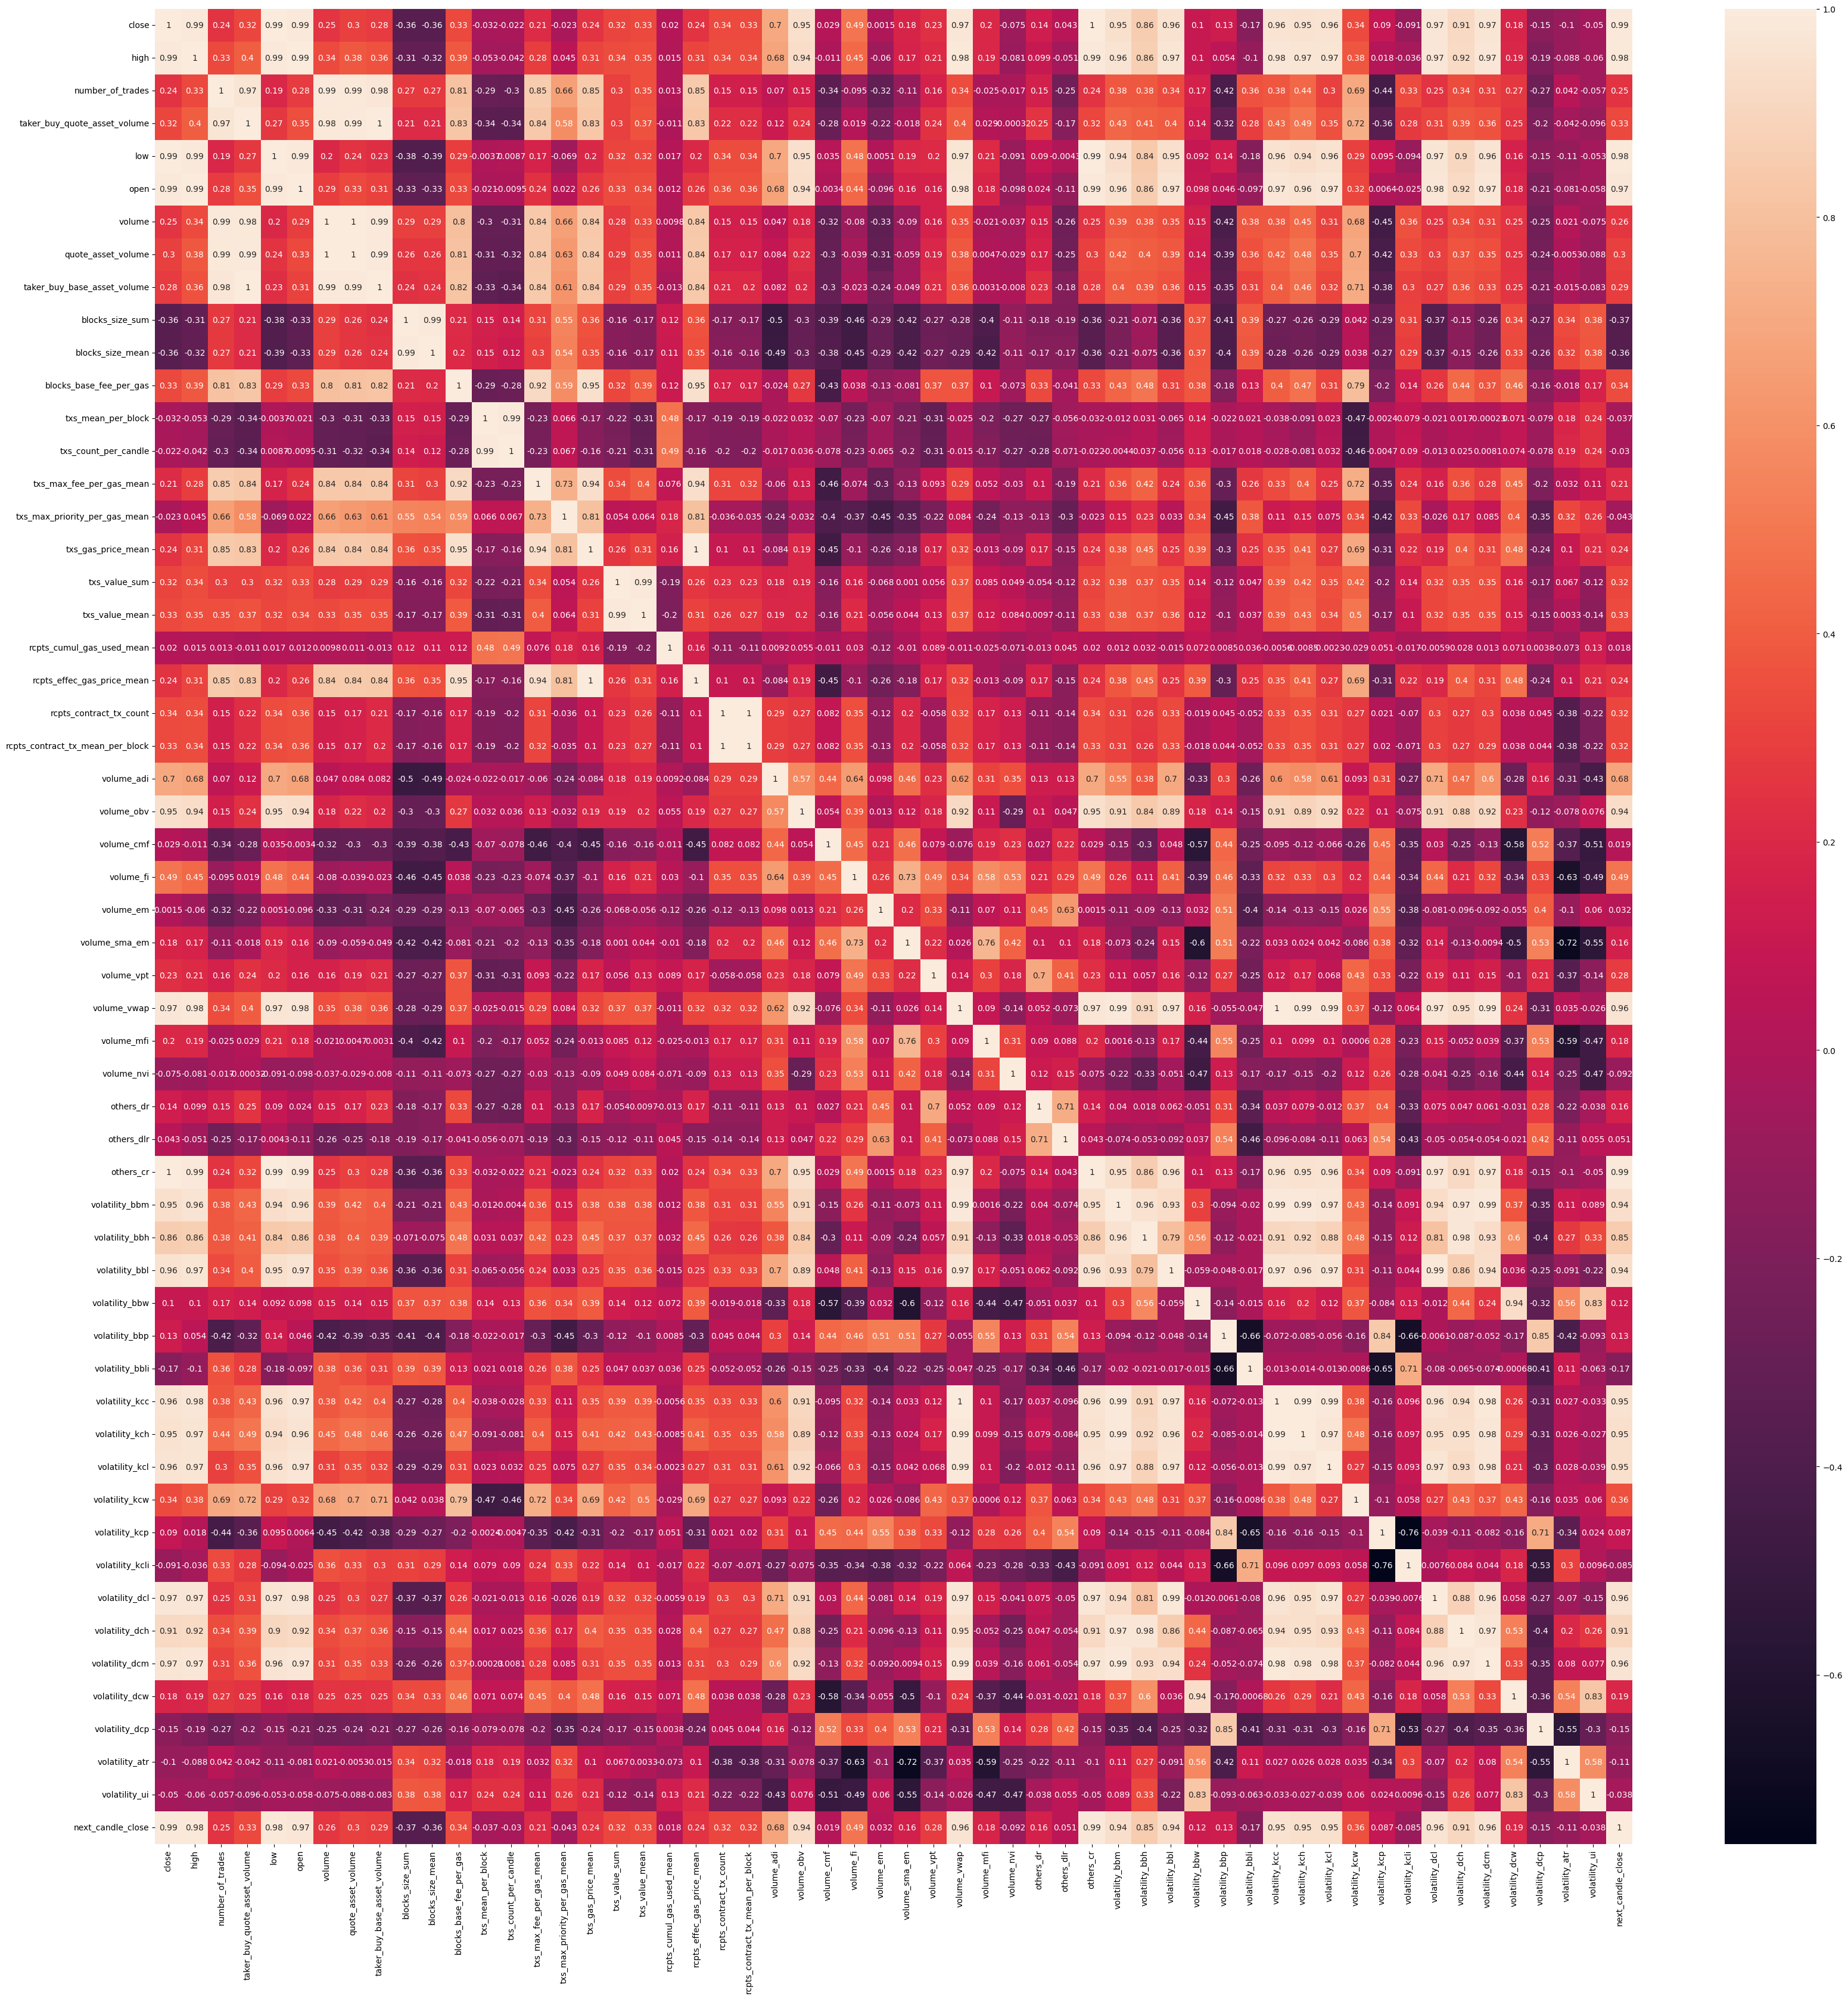

In [17]:
plt.figure(figsize=(40, 40))
corr = data.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show();

Some of the features were removed from the data because they were found to be highly correlated with other features. This can be determined by looking at the correlation matrix which measures the relationship between different features. Features that have a correlation value close to 1 or 0 were removed to make sure the model uses independent and non-redundant features, which leads to more accurate predictions. In simple terms, this means that some features were removed because they were found to be very similar or opposite to other features, and therefore were not needed for the model.

In [18]:
cont_features = ["low", "open", "volume", "quote_asset_volume",
       "taker_buy_base_asset_volume", "high", "number_of_trades", "taker_buy_quote_asset_volume",
       "blocks_size_sum", "blocks_size_mean", "blocks_base_fee_per_gas",
       "txs_max_fee_per_gas_mean",
       "txs_gas_price_mean", "txs_value_sum", "txs_value_mean", 
       "rcpts_effec_gas_price_mean",
       "rcpts_contract_tx_count", "rcpts_contract_tx_mean_per_block",
       "volume_adi", "volume_obv", "volume_fi",
       "volume_sma_em", "volume_vpt", "volume_vwap", "volume_mfi",
       "volume_nvi", "others_dr", "volatility_bbm",
       "volatility_bbh", "volatility_bbl", "volatility_bbw",
       "volatility_bbli", "volatility_kcc", "volatility_kch", "volatility_kcl",
       "volatility_kcw", "volatility_kcp", "volatility_kcli", "volatility_dcl",
       "volatility_dch", "volatility_dcm", "volatility_dcw"]

label = "next_candle_close"

In [19]:
cont_pipeline = Pipeline([
    ("scaler", StandardScaler()),
])

### Baseline model (Linear ragression)

In [20]:
pipeline = Pipeline([
    ("ColumnTransformer", ColumnTransformer([
        ("cont_transformer", cont_pipeline, cont_features),
    ])),
    ("model", LinearRegression())
])

In [21]:
train_df, test_df = train_test_split(data,test_size=0.2)
print("Train size: ", train_df.size)
print("Test size: ", test_df.size)

Train size:  6728
Test size:  1682


In [22]:
pipeline.fit(train_df, train_df[label].values)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('cont_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['low', 'open', 'volume',
                                                   'quote_asset_volume',
                                                   'taker_buy_base_asset_volume',
                                                   'high', 'number_of_trades',
                                                   'taker_buy_quote_asset_volume',
                                                   'blocks_size_sum',
                                                   'blocks_size_mean',
                                                   'blocks_base_fee_per_gas',
                                                   'txs_max_fee_per_gas_...
                                                   'txs_gas_price_mean',
                                                   'txs_value_sum',
                                                   'txs_value_mean',
                                                   'rcpts_effec_gas_price_mean',
                                                   'rcpts_contract_tx_count',
                                                   'rcpts_contract_tx_mean_per_block',
                                                   'volume_adi', 'volume_obv',
                                                   'volume_fi', 'volume_sma_em',
                                                   'volume_vpt', 'volume_vwap',
                                                   'volume_mfi', 'volume_nvi',
                                                   'others_dr',
                                                   'volatility_bbm',
                                                   'volatility_bbh',
                                                   'volatility_bbl', ...])])),
                ('model', LinearRegression())])

In [23]:
print("LinearReg")
predictions = pipeline.predict(test_df)
print("MAE: ", mean_absolute_error(test_df[label], predictions))
print("MSE: ", mean_squared_error(test_df[label], predictions))

LinearReg
MAE:  18.28235514404155
MSE:  1931.8559237549605


In [24]:
test_df.head(1)

,close,open_time,high,close_time,number_of_trades,taker_buy_quote_asset_volume,low,open,volume,quote_asset_volume,taker_buy_base_asset_volume,blocks_size_sum,blocks_size_mean,blocks_base_fee_per_gas,txs_mean_per_block,txs_count_per_candle,txs_max_fee_per_gas_mean,txs_max_priority_per_gas_mean,txs_gas_price_mean,txs_value_sum,txs_value_mean,rcpts_cumul_gas_used_mean,rcpts_effec_gas_price_mean,rcpts_contract_tx_count,rcpts_contract_tx_mean_per_block,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,others_dr,others_dlr,others_cr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,next_candle_close
4,1636.65,2022-09-15 07:45:00,1637.13,2022-09-15 07:59:59.999,20985,12064050.39,1626.52,1630.82,16930.27,27642820.80,7388.72,4656999,62093.32,20707518254.73,170.44,12783,72810291642.60,3885366441.83,24884323388.83,135120782842834020466688.00,10570349905564735488.00,9555394.49,24884323388.83,285,3.80,26203.45,143037.74,0.14,518399.28,-8146.94,527632.35,-18.51,1619.30,79.49,1012.58,0.36,0.36,2.30,1624.52,1652.14,1596.90,3.40,0.72,0.00,1623.54,1652.62,1594.46,3.58,0.73,0.00,1580.10,1655.00,1617.55,4.61,0.76,0.00,0.00,1623.55


In [25]:
pipeline.predict(test_df.head(1))

array([1630.14601509])

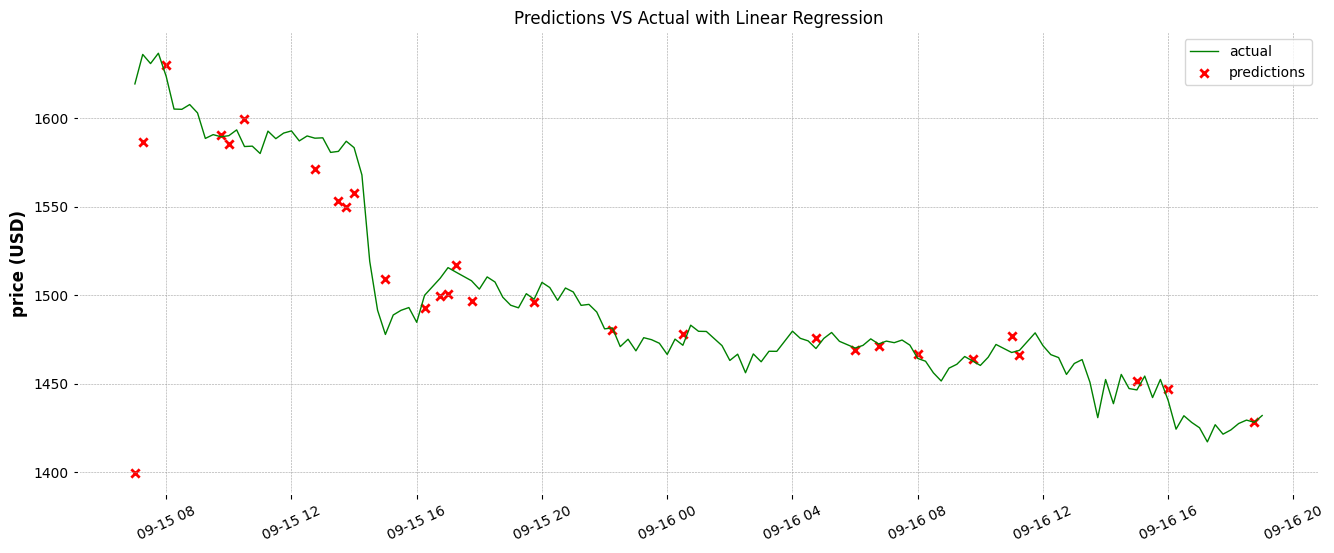

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data[label], color="green", label="actual", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df), color="red", label="predictions", marker="x")
ax.set_title("Predictions VS Actual with Linear Regression")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.legend()
plt.show();

In [27]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [28]:
feature_names = get_feature_names(pipeline.named_steps["ColumnTransformer"])

/var/folders/jt/jttvrgbx7pxgyn407jvmp9000000gn/T/ipykernel_17999/2197783060.py:30: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [29]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Weight?,Feature
+254172440200207.688,cont_transformer__volatility_kch
+230764148899761.438,cont_transformer__volatility_kcl
+52615326684750.586,cont_transformer__txs_gas_price_mean
+13118193800088.068,cont_transformer__volatility_bbm
+12960226971292.225,cont_transformer__volatility_dch
+10412379936647.455,cont_transformer__volatility_dcl
+1493.296,<BIAS>
+183.605,cont_transformer__volume
+122.131,cont_transformer__volatility_kcw
+113.862,cont_transformer__volatility_bbw


# XGBoost Regressor

In [30]:
pipeline = Pipeline([
    ("model", XGBRegressor())
])

In [31]:
# Searching for the best hyperparams

def extract_best_model_params(params: Dict[str, Any]) -> Dict[str, Any]:
    filtered_dict = {}
    for key, value in params.items():
        if "model__" in key:
            filtered_dict[key.split("model__")[-1]] = value
    return filtered_dict

### A hyperparameter tuning for an XGBoost regression model using RandomizedSearchCV.

In [74]:

params = {
    "model__max_depth": [1, 50],
    "model__learning_rate": [0.01, 0.5],
    "model__colsample_bylevel": [0.1, 0.9],
}

forrest = pipeline

search = RandomizedSearchCV(forrest, params, n_iter=8, cv=7, random_state=42, n_jobs=-1)
search.fit(train_df[cont_features], train_df[label].values)
print(extract_best_model_params(search.best_estimator_.get_params()))


pipeline = Pipeline(
    [
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df[cont_features], train_df[label].values)

predictions = pipeline.predict(test_df[cont_features])

print("MAE: ", mean_absolute_error(test_df[label], predictions))
print("MSE: ", mean_squared_error(test_df[label], predictions))

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.9, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.5, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
MAE:  12.142668541217667
MSE:  368.6204757184148


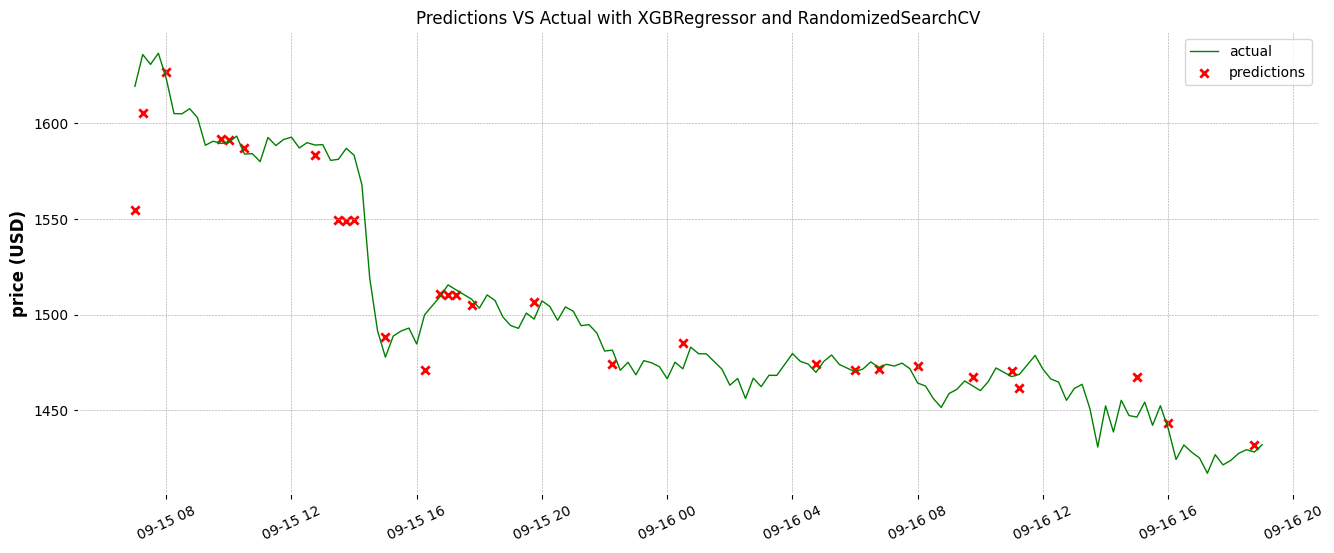

In [75]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data[label], color="green", label="actual", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df[cont_features]), color="red", label="predictions", marker="x")
ax.set_title("Predictions VS Actual with XGBRegressor and RandomizedSearchCV")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.legend()
plt.show();

### A hyperparameter tuning for an XGBoost regression model using GridSearchCV.

In [77]:
params = {
    "model__max_depth": [1, 100],
    "model__learning_rate": [0.00001, 0.9],
    "model__colsample_bylevel": [0.5, 0.9],
}

forrest = pipeline

search = GridSearchCV(forrest, params, cv=9, n_jobs=-1)
print(extract_best_model_params(search.get_params()))
search.fit(train_df[cont_features], train_df[label].values)


pipeline = Pipeline(
    [
        ("model", XGBRegressor(**extract_best_model_params(search.best_estimator_.get_params()))),
    ]
)
pipeline.fit(train_df[cont_features], train_df[label].values)

predictions = pipeline.predict(test_df[cont_features])

print("MAE: ", mean_absolute_error(test_df[label], predictions))
print("MSE: ", mean_squared_error(test_df[label], predictions))

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.9, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.9, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 1, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
MAE:  8.234817988954742
MSE:  120.74109511779827


## Conclusion

Based on the metrics, it can be concluded that the model has a good performance in predicting the next candle close price. The Mean Absolute Error (MAE) of 8.23 and the Mean Squared Error (MSE) of 120.74 are both relatively low, indicating that the model's predictions are close to the actual values. The model uses XGBoost regression algorithm and the best hyperparameters were max_depth of 1, learning_rate of 0.9 and colsample_bylevel of 0.9. However, it's worth noting that the performance of the model should be evaluated on unseen data as well to ensure its generalization ability.


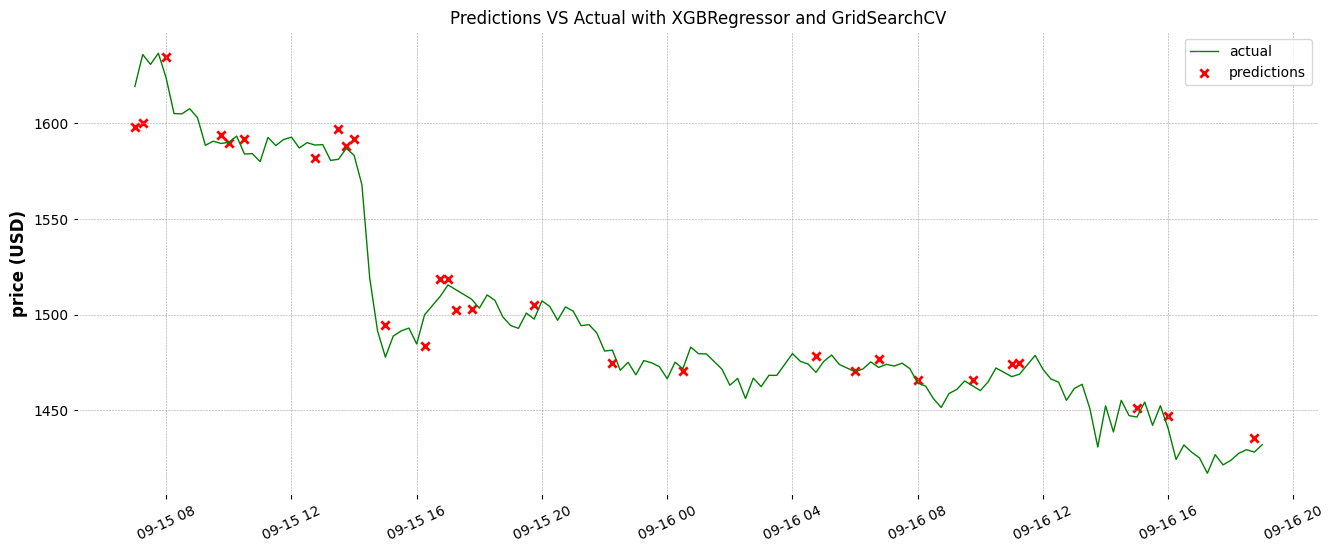

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.plot(data["close_time"], data[label], color="green", label="actual", lw=1)
ax.scatter(test_df["close_time"], pipeline.predict(test_df[cont_features]), color="red", label="predictions", marker="x")
ax.set_title("Predictions VS Actual with XGBRegressor and GridSearchCV")
ax.set_ylabel("price (USD)")
plt.xticks(rotation=25)
plt.legend()
plt.show();

In [79]:
cloudpickle.dump(pipeline, open("notebooks/models/model.pkl", "wb"))

### Credits
descriptions by <a href="https://chat.openai.com/">ChatGPT</a>